# Setup
## Import and git root

In [236]:

import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git


from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl


In [203]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway reference variables

In [204]:
bd.projects.set_current('SEE_LAB') 

# Exploration
## Brightway (pre-existing)

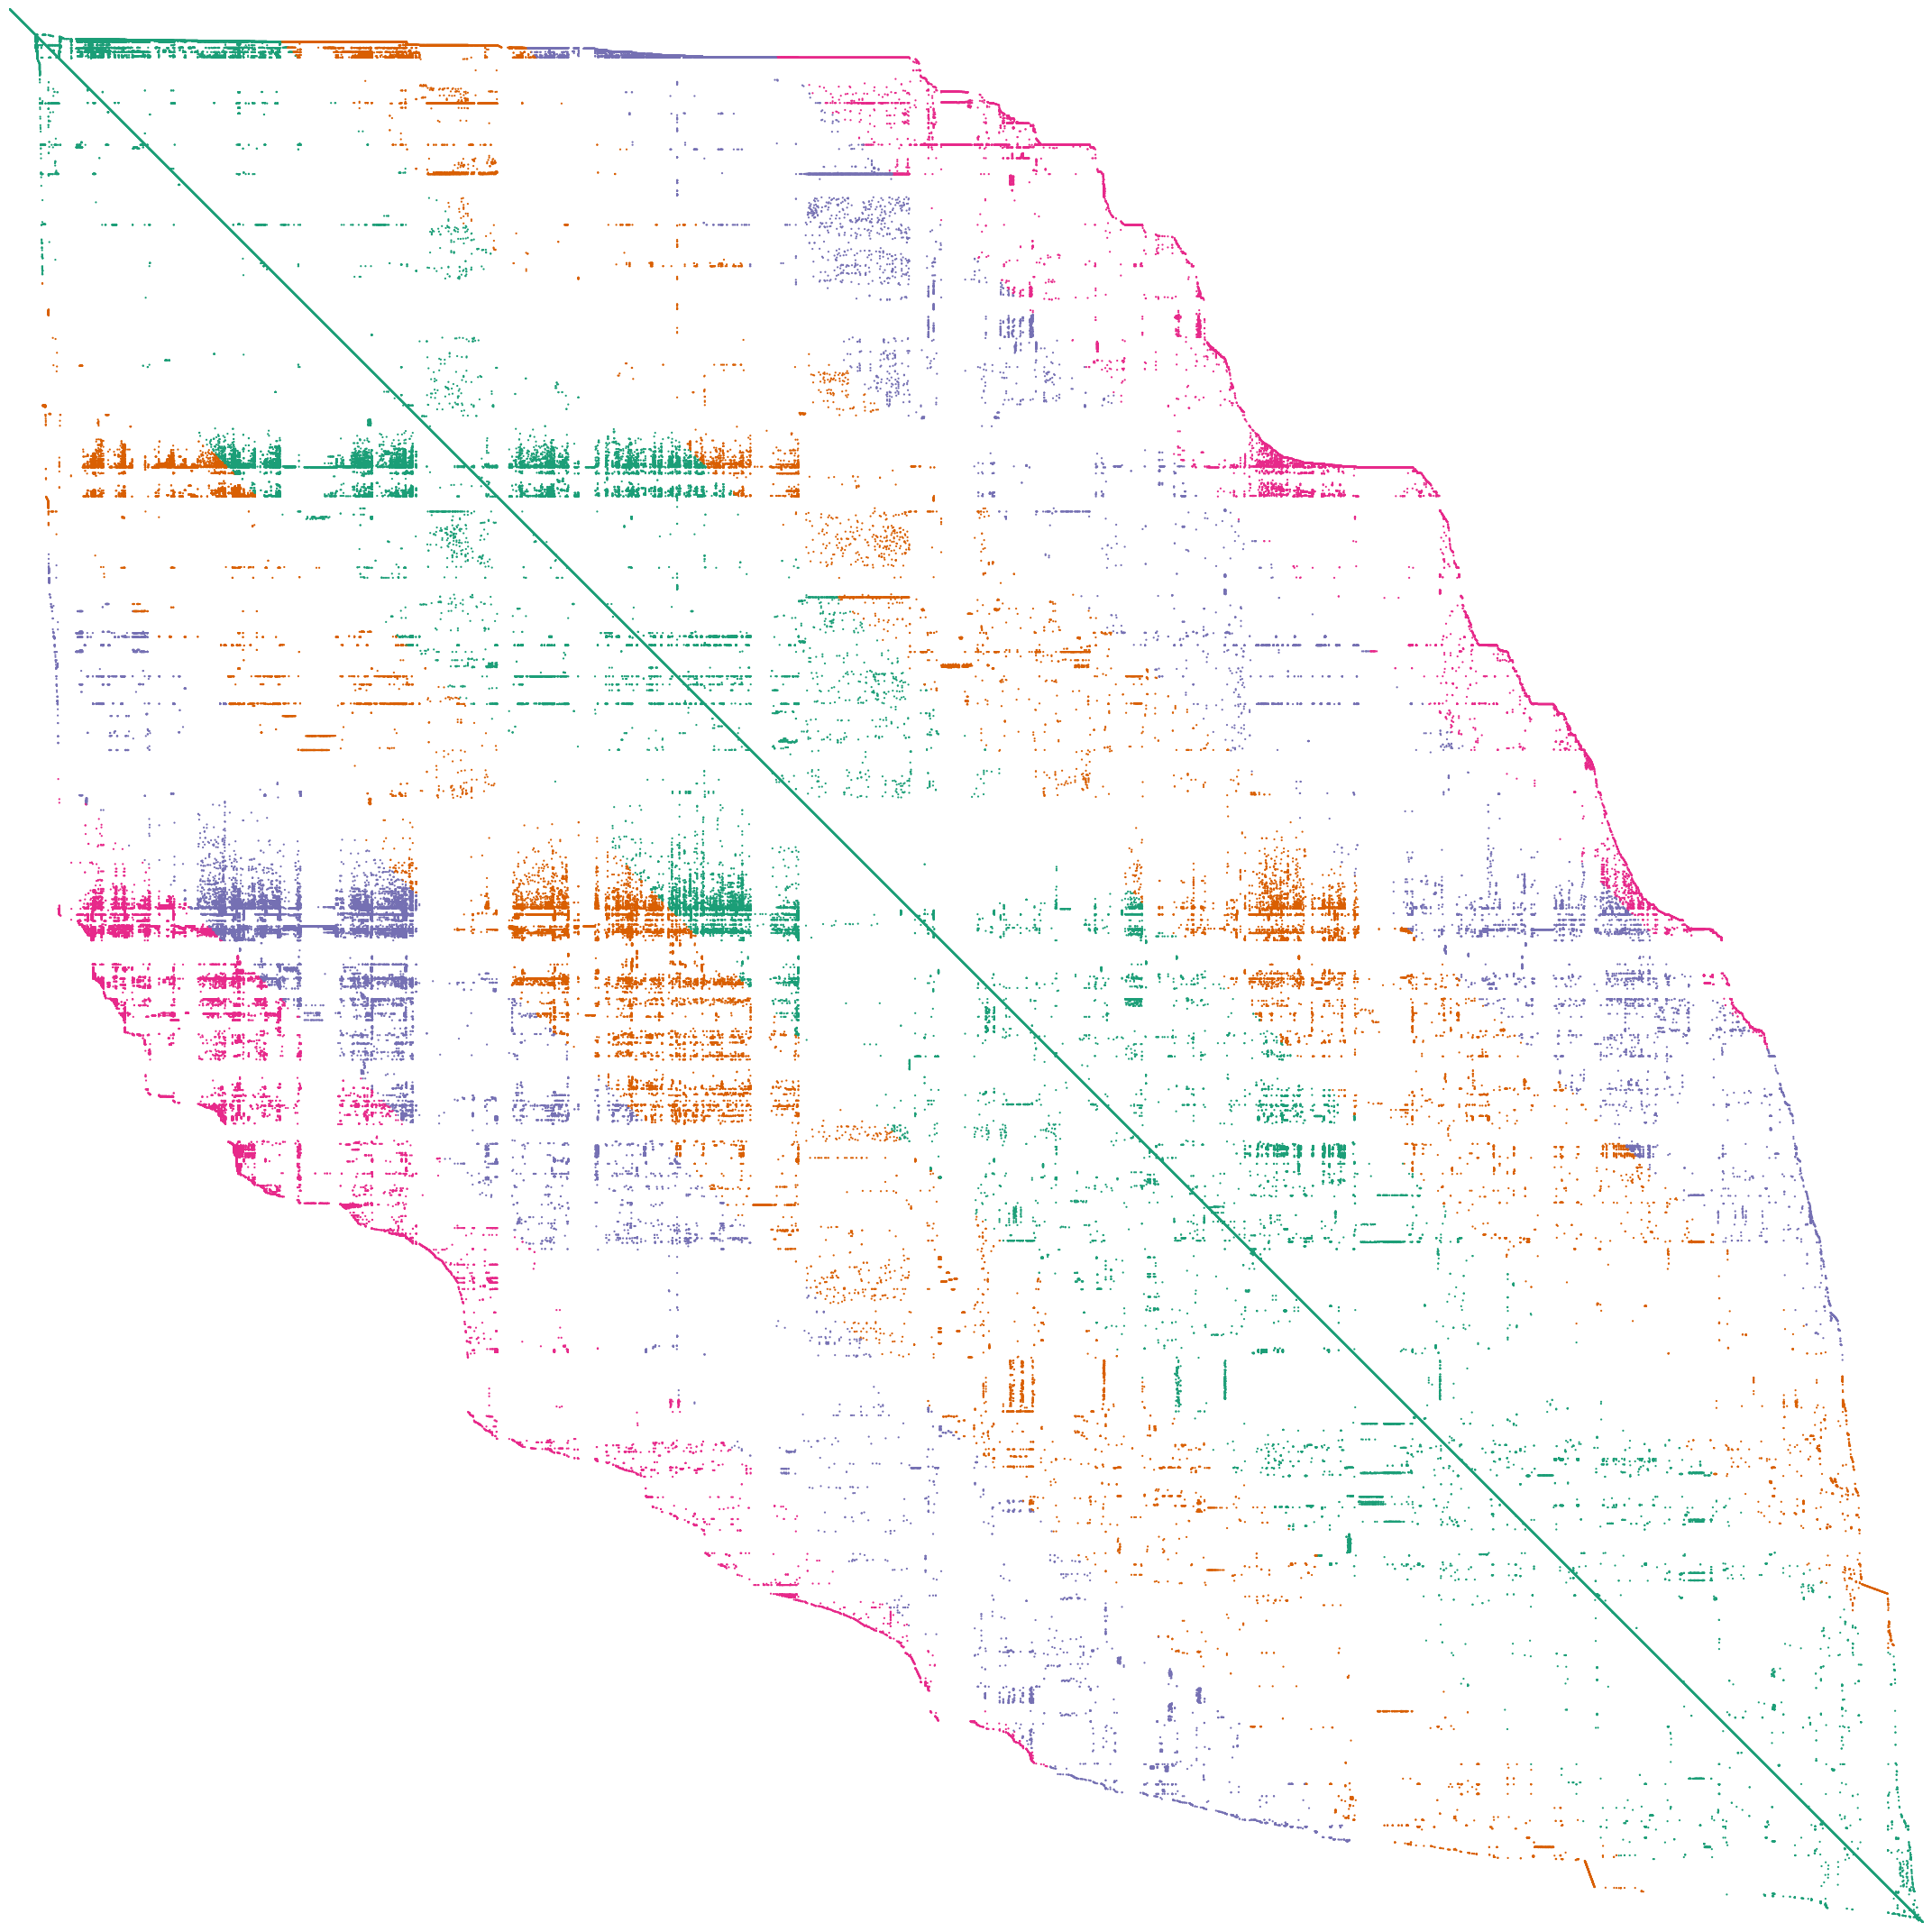

In [205]:
eidb = bd.Database("ecoinvent-3.9.1-cutoff")
eidb.graph_technosphere()


In [206]:
random_act = eidb.random()
random_act.as_dict()

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset represents the supply of 1 kg of \'sunflower seed, Swiss integrated production\' from activities that produce it within the geography of CH. Transportation is included in this market, based on Valsasina, L. (2016), "Default transport data per commodity group for Switzerland, ecoinvent database version 3.3, ecoinvent Centre, Zürich, Switzerland", available on the ecoinvent\'s website http://www.ecoinvent.org/. More details can be found in the exchange comments of the transportation. \nIncluded activities start:  This activity starts at the gate of the activiti

In [207]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 1.0 kilogram 'sunflower production, Swiss integrated production, intensive' (kilogram, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 0.00882 ton kilometer 'market for transport, freight train' (ton kilometer, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 0.0583215915997692 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>


In [208]:
[exc for exc in random_act.exchanges()][0].as_dict()


{'flow': '5a2e2911-c8f0-4927-957b-b869a10bcf8b',
 'type': 'production',
 'name': 'sunflower seed, Swiss integrated production',
 'classifications': {'CPC': ['01445: Sunflower seed']},
 'production volume': 15100000.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.1155987277788999,
   'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when producing any product. These expences can include for example labour costs, treatment of waste materials and profit for the producer. Please consider carefully whether this level of data quality is acceptable for your application.',
   'unit': 'EUR2005'}},
 'activity': '1c133716-f271-5690-b628-37d1a15aa78a',
 'unit': 'kilogr

## Original (trivial)
### Explore Activity Country Tags (all)
First we'll look at all the technosphere processes

In [209]:
## Create a dictionary of all the country codes counts (from the technosphere activities) and convert to a dataframe
global_dict = defaultdict(int)
for act in eidb:
    cc_code = act['location']
    global_dict[cc_code] += 1

country_frame  = pd.DataFrame(list(global_dict.items()), columns=['Country', 'Count'])
country_frame

,Country,Count
0,CH,2044
1,RoW,4210
2,CN-CQ,13
3,NZ,19
4,SA,22
...,...,...
304,IN-DD,1
305,RER w/o DE+NL+RU,1
306,Europe without Switzerland and Austria,1
307,WEU,2


We want to look at these as a map; this requires:
* shapesfiles for each country region (eg a global shapefile with provinces included)
* a dictionary or map to get from each country code to each shapefile 

Luckily, the database overview has a geographies sheet. We merge this now. 

In [210]:
geographies = pd.read_excel(f"{root}/Data/Database-Overview-for-ecoinvent-v3.10_29.04.24.xlsx", sheet_name="Geographies")
country_frame = pd.merge(
    left=country_frame,
    right=geographies,
    how='inner',
    left_on='Country',
    right_on='Shortname'
)
country_frame.drop(columns='Country', inplace=True)
country_frame.sort_values(by='Count', ascending=False).head(10)

,Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
1,4210,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN
6,4025,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...
0,2044,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN
13,1700,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
7,521,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
29,419,868a66d1-7428-4ba2-9125-253b07afc119,"Canada, Québec",CA-QC,53.390446,-71.755869,Province or State,NaN
24,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...
41,295,12b21766-7d7e-11de-9ae2-0019e336be3a,South Africa,ZA,-30.558000,23.121000,Country,NaN
84,259,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...
22,238,0e6a7860-7d7e-11de-9ae2-0019e336be3a,India,IN,21.000000,78.500000,Country,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...


Explore the distribution a little 

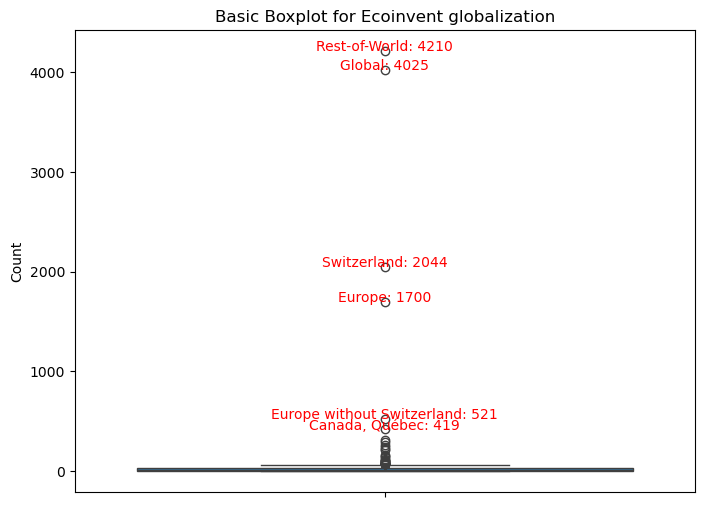

In [211]:
top5 = country_frame.sort_values(by='Count', ascending=False).head(6).copy()

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=country_frame, y='Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Count'], f"{outlier['Name']}: {outlier['Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

Note that:

* Global means global average production -- it **always** means that.
* Rest of World (RoW) means all the activites NOT explicitly locally defined. For example, if you have Switzerland and USA, than RoW means the global average minus those countries (from both numerator and denominator). Importantly, this means that RoW is **different** for every process (because they have different amounts of regional data)
* RoW values are not included if the regional values leave <.5% of the global production volume.

This means that in order to map RoW accurately we'll have to 'subtract' the process values we have (for that process)

Source: https://support.ecoinvent.org/geographies

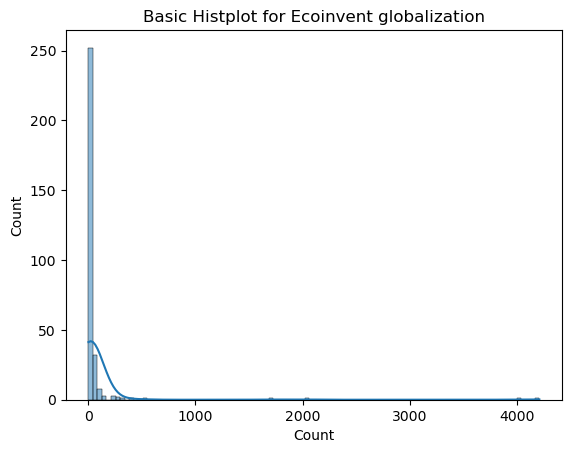

In [212]:
## Explore the distribution a little bit ... 
sns.histplot(data=country_frame['Count'], bins=100, kde=True)
plt.title("Basic Histplot for Ecoinvent globalization")
plt.show()

In [224]:
states = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_states_provinces_all/ne_10m_admin_1_states_provinces.shp")
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [214]:
country_frame.shape

(307, 8)

In [245]:
matched_territories = pd.merge(
    left = country_frame,
    right = states,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_3166_2'
)
matched_territories

countries_left = country_frame[~country_frame['Shortname'].isin(matched_territories['Shortname'])]
countries_left

states_unique = states.drop_duplicates(subset='iso_a2')
states_unique

matched_countries = pd.merge(
    left = countries_left,
    right = states_unique,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_a2'
)

matched_all = pd.concat([matched_territories, matched_countries])
matched_all.head(2)



,Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,featurecla,scalerank,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,13,8bc809e8-f246-46f7-bf1f-93e34e06befd,"China, Chongqing (重庆)",CN-CQ,NaN,NaN,Province or State,NaN,Admin-1 states provinces,2,...,None,None,None,None,None,None,None,None,None,"POLYGON ((107.81154 30.79802, 107.82492 30.798..."
1,14,9923dac7-3164-4e2f-8723-f343d998072d,"China, Hunan (湖南)",CN-HN,NaN,NaN,Province or State,NaN,Admin-1 states provinces,2,...,None,None,None,None,None,None,None,None,None,"POLYGON ((109.25838 28.50591, 109.26272 28.527..."


In [251]:
frames = [matched_countries, matched_territories, matched_all]
for frame in frames:
    frame = gpd.GeoDataFrame(frame, geometry='geometry')
    frame.set_crs('EPSG:4326', allow_override=True, inplace=True)



In [256]:
def plot_name_cols_geo(visframe, cmap_,  hue_col=None, 
                       cbar_label="Cbar_Label",  verbose=True, tick_changer=None):
    """
    Plot geo-data with "xcol : ycol" on each different shape.

    :param visframe: the geopandas frame to plot from
    :param cmap_: the color map to encode the shapes with (according to ycol)
    :param xcol: the variable to print but not encode
    :param ycol: the variable to print and encode
    :param ax_: the matplotlib axis to put it on. For subplotting in one figure.

    :returns: Nothing. just prints. 

    """
    visframe = visframe.copy()
    ax_.axis("off")
    if tick_changer:
            visframe[hue_col] = visframe[hue_col].apply(tick_changer)
    visframe.plot(column=hue_col, ax=ax_, cmap=cmap_)
    
    if verbose:
        # for geom, x, y in zip(visframe.geometry, visframe[xcol], visframe[ycol]):
        #     if y is not None:  # Check if the value is not NaN so that we don't try to text untextable things
        #         point = geom.representative_point()
        #         if going:            label = f"{x} -> {y}"
        #         else: label = f"{x} <-  {y}" 
        #         ax_.text(point.x, point.y, label, fontsize=8, ha='center', color='black')

        norm = mpl.colors.TwoSlopeNorm(vmin=visframe[hue_col].min(), vmax=visframe[hue_col].max(), vcenter=0)
        sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm) 
        cbar = plt.colorbar(sm, ax=ax_)

         
        # Create ticks from min to 0 and from 0 to max
        ticks_min_to_0 = np.linspace(visframe[hue_col].min(), 0, num=5)  # Customize 'num' as needed
        ticks_0_to_max = np.linspace(0, visframe[hue_col].max(), num=5)  # Customize 'num' as needed

        # Combine the two tick ranges
        ticks = np.concatenate([ticks_min_to_0, ticks_0_to_max[1:]])  # Avoid duplicate 0
        ticks = np.sort(ticks)

        #Customize the legend
        cbar.set_label(cbar_label)
        cbar.set_ticks(ticks)  # dynamic ticks
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])  


In [257]:
for frame in frames:
    cmap = plt.get_cmap('YlOrRd', frame['Count'].max() )
    plot_name_cols_geo(frame, cmap)

TypeError: plot_name_cols_geo() missing 3 required positional arguments: 'xcol', 'ycol', and 'ax_'